<a href="https://colab.research.google.com/github/mustafabozkaya/arge-odakli-yapay-zeka-egitimi2-sorulari/blob/main/movie_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import os
for dirname, _, filenames in os.walk(''):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [3]:
!mkdir working
%cd working


/content/working


In [4]:
%pwd

'/content/working'

In [7]:
#!wget https://github.com/mustafabozkaya/arge-odakli-yapay-zeka-egitimi2-sorulari/tree/main/datasets/movies.csv datasets
!git clone https://github.com/mustafabozkaya/arge-odakli-yapay-zeka-egitimi2-sorulari.git 

Cloning into 'arge-odakli-yapay-zeka-egitimi2-sorulari'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 41 (delta 10), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (41/41), done.


In [9]:
#!wget https://github.com/mustafabozkaya/arge-odakli-yapay-zeka-egitimi2-sorulari/tree/main/datasets/ratings.csv

In [10]:
#!wget https://github.com/mustafabozkaya/arge-odakli-yapay-zeka-egitimi2-sorulari/tree/main/datasets/README.txt

# **Load Library**

In [45]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import re
from PIL import Image
import requests
import random
from sklearn.feature_extraction.text import CountVectorizer



In [14]:
!pip install -q nltk

In [ ]:
import nltk # Natural Language Tool Kit 
from nltk.corpus import stopwords # Stopwords corpus is a list of commonly used words in a language

In [12]:
os.listdir("./arge-odakli-yapay-zeka-egitimi2-sorulari/datasets/")

['movies.csv', 'README.txt', 'ratings.csv']

In [13]:
!cat ./arge-odakli-yapay-zeka-egitimi2-sorulari/README.md

# Araştırma ve Geliştirme Odaklı Yapay Zeka Eğitimi Soruları


Başvuru kabulü için size sorulan soruyu çözmenizden çok, o soruyu çözmek için ne kadar uğraştığınız önemlidir. Motivasyonu yüksek gençlerle çalışmak çok farklı, bunu biliyoruz, sizi önemsiyoruz ve bekliyoruz.
 
## Soru - Film Önerme
MovieLens verisetini kullanarak kişilere film önerisi yapan bir fonksiyon geliştirmeniz beklenmektedir. Aşağıdaki notebook'u temel alarak çalışmanızı yapabilirsiniz. 

- [Film Önerme](https://github.com/kaveai/arge-odakli-yapay-zeka-egitimi2-sorulari/blob/main/Soru1.ipynb)


## Data Story

In [15]:
!cat ./arge-odakli-yapay-zeka-egitimi2-sorulari/datasets/README.txt

Summary

This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.

Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in the files `links.csv`, `movies.csv`, `ratings.csv` and `tags.csv`. More details about the contents and use of all these files follows.

This is a *development* dataset. As such, it may change over time and is not an appropriate dataset for shared research results. See available *benchmark* datasets if that is your intent.

This and other GroupLens data sets are publicly available for down

## Load & Check Datasets

In [16]:
dataset_dir="./arge-odakli-yapay-zeka-egitimi2-sorulari/datasets/"

In [17]:
movies = pd.read_csv(dataset_dir+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [36]:
ratings = pd.read_csv(dataset_dir+'ratings.csv',parse_dates=["timestamp"])
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [37]:
print("Movie Shape: " ,movies.shape )
print("Ratings Shape: " ,ratings.shape )

print("Any null values in Movie:" ,movies.isnull().values.any())
print("Any null values in Ratings: ",ratings.isnull().values.any())


print("How many null values in Which Movie's feature:\n" ,movies.isnull().sum())
print("How many null values in Which Ratings's feature:\n ",ratings.isnull().sum())


Movie Shape:  (9742, 3)
Ratings Shape:  (100836, 4)
Any null values in Movie: False
Any null values in Ratings:  False
How many null values in Which Movie's feature:
 movieId    0
title      0
genres     0
dtype: int64
How many null values in Which Ratings's feature:
  userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


## Concanate Datasets

In [38]:
# MovieID üzerinden kişilerin yorumlarına film isimlerini ve genrelerini ekliyoruz. 
df = pd.merge(ratings, movies, how='left', on='movieId')

df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [39]:
# fro faster processing of large size data 
# we save it as a parquet file or pickle file
# but parquet  takes up less space 
df.to_parquet("ratesmovies.parquet",compression="gzip") 
df.to_pickle("ratesmovies.pickle")

In [40]:
rating_movie=pd.read_parquet("ratesmovies.parquet")

## Exploratary Data analysis

In [41]:
rating_movie.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  object 
 4   title      100836 non-null  object 
 5   genres     100836 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 5.4+ MB


In [42]:
rating_movie.describe()

,userId,movieId,rating
count,100836.000000,100836.000000,100836.000000
mean,326.127564,19435.295718,3.501557
std,182.618491,35530.987199,1.042529
min,1.000000,1.000000,0.500000
25%,177.000000,1199.000000,3.000000
50%,325.000000,2991.000000,3.500000
75%,477.000000,8122.000000,4.000000
max,610.000000,193609.000000,5.000000


In [43]:
rating_movie.rating.value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

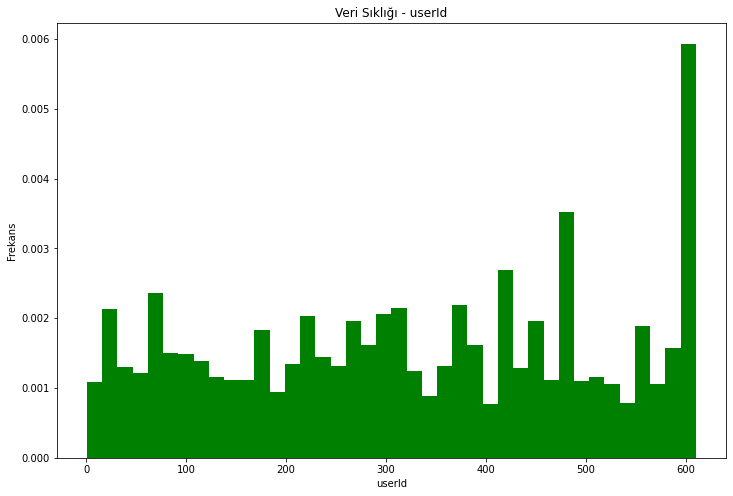

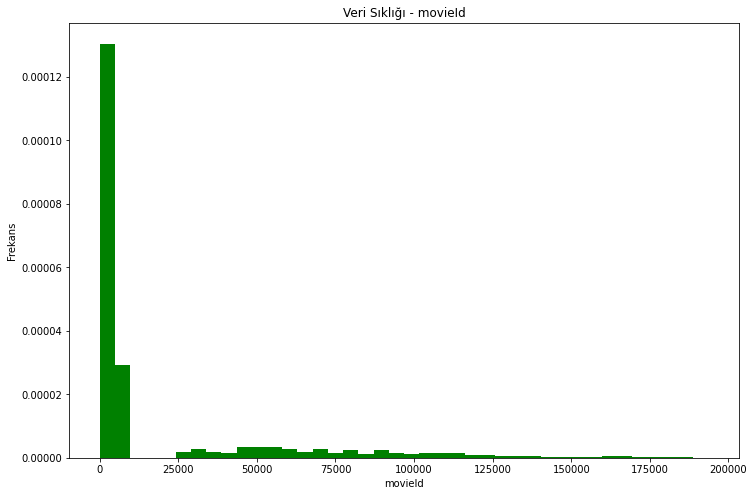

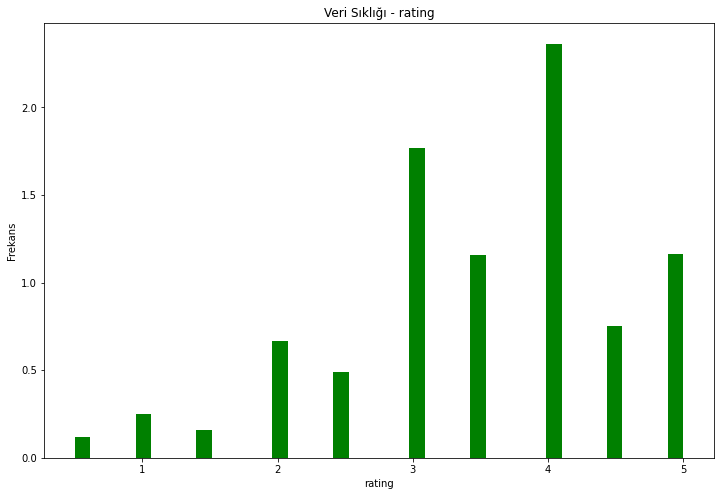

In [48]:
def plotHistogram(degisken):
    plt.figure(figsize=(12,8))
    plt.hist(rating_movie[degisken],bins=40,color="green",density=True)
    plt.xlabel(degisken)
    plt.ylabel("Frekans")
    plt.title("Veri Sıklığı - {}".format(degisken))
    plt.show()

sayisal_degisken=rating_movie.select_dtypes([np.number]).columns
for i in sayisal_degisken:
    plotHistogram(i)

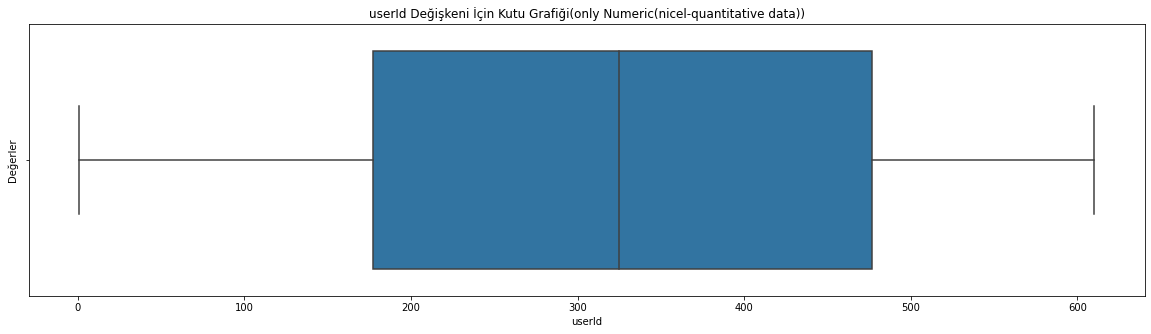

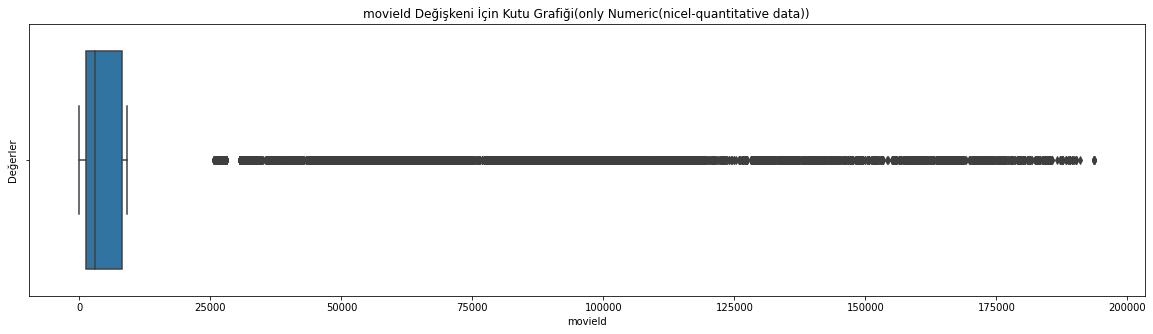

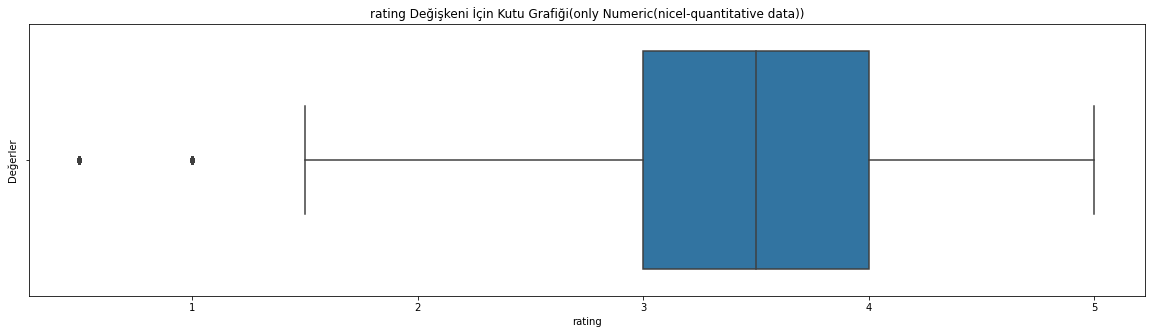

In [49]:
def plotbox(numericvar):
    # setting the dimensions of the plot
    fig, ax = plt.subplots(figsize=(20, 5))
    sns.boxplot(x=rating_movie[numericvar])
    plt.title(f"{numericvar} Değişkeni İçin Kutu Grafiği(only Numeric(nicel-quantitative data))")
    plt.xlabel(numericvar)
    plt.ylabel("Değerler")
    plt.show()
for var in rating_movie.select_dtypes(exclude=["object","category","datetime"]).columns:
    plotbox(var)

<Figure size 1800x1080 with 0 Axes>

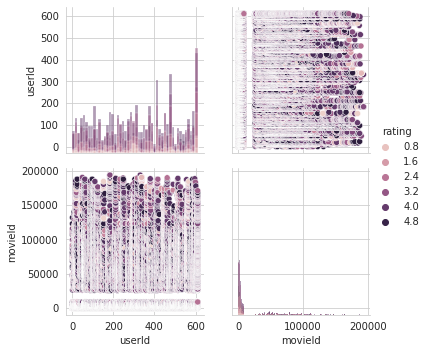

In [56]:
plt.figure(figsize=(25,15))
sns.set_style(style="whitegrid")

g = sns.PairGrid(rating_movie, hue="rating")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

## Preprocessing

In [ ]:
def preprocess(df):
  df=df.copy()
  df.dropna(inplace=True)
  df.reset_index(drop=True,inplace=True)
  df.drop(index=df[df["Book-Rating"]==0].index,inplace=True)
  df["title"]=df["title"].apply(lambda x: re.sub("[\W_]+"," ",x).strip())
  df.head()

## ITEM-BASED COLLABORATIVE FILTERING

In [ ]:

def item_based(bookTitle):
    bookTitle=str(bookTitle)
    
    if bookTitle in df["Book-Title"].values:
        rating_count=pd.DataFrame(df["Book-Title"].value_counts())
        rare_books=rating_count[rating_count["Book-Title"]<=200].index
        common_books=df[~df["Book-Title"].isin(rare_books)]
        
        if bookTitle in rare_books:
            most_common=pd.Series(common_books["Book-Title"].unique()).sample(3).values
            print("No Recommendations for this Book ☹️ \n ")
            print("YOU MAY TRY: \n ")
            print("{}".format(most_common[0]), "\n")
            print("{}".format(most_common[1]), "\n")
            print("{}".format(most_common[2]), "\n")
        else:
            common_books_pivot=common_books.pivot_table(index=["User-ID"],columns=["Book-Title"],values="Book-Rating")
            title=common_books_pivot[bookTitle]
            recommendation_df=pd.DataFrame(common_books_pivot.corrwith(title).sort_values(ascending=False)).reset_index(drop=False)
            
            if bookTitle in [title for title in recommendation_df["Book-Title"]]:
                recommendation_df=recommendation_df.drop(recommendation_df[recommendation_df["Book-Title"]==bookTitle].index[0])
                
            less_rating=[]
            for i in recommendation_df["Book-Title"]:
                if df[df["Book-Title"]==i]["Book-Rating"].mean() < 5:
                    less_rating.append(i)
            if recommendation_df.shape[0] - len(less_rating) > 5:
                recommendation_df=recommendation_df[~recommendation_df["Book-Title"].isin(less_rating)]
                
            recommendation_df=recommendation_df[0:5]
            recommendation_df.columns=["Book-Title","Correlation"]
            
            fig, ax = plt.subplots(1,5,figsize=(17,5))
            fig.suptitle("WOULD YOU LIKE to TRY THESE BOOKS?",fontsize=40,color="deepskyblue")
            for i in range(len(recommendation_df["Book-Title"].tolist())):
                url=df.loc[df["Book-Title"]==recommendation_df["Book-Title"].tolist()[i],"Image-URL-L"][:1].values[0]
                img=Image.open(requests.get(url,stream=True).raw)
                ax[i].imshow(img)
                ax[i].axis("off")
                ax[i].set_title("RATING: {} ".format(round(df[df["Book-Title"]==recommendation_df["Book-Title"].tolist()[i]]["Book-Rating"].mean(),1)),y=-0.20,color="mediumorchid",fontsize=22)
                fig.show()
    else:
        print("❌ COULD NOT FIND ❌")

## CONTENT-BASED COLLABORATIVE FILTERING

In [ ]:

def content_based(bookTitle):
    bookTitle=str(bookTitle)
    
    if bookTitle in df["Book-Title"].values:
        rating_count=pd.DataFrame(df["Book-Title"].value_counts())
        rare_books=rating_count[rating_count["Book-Title"]<=200].index
        common_books=df[~df["Book-Title"].isin(rare_books)]
        
        if bookTitle in rare_books:
            most_common=pd.Series(common_books["Book-Title"].unique()).sample(3).values
            print("No Recommendations for this Book ☹️ \n ")
            print("YOU MAY TRY: \n ")
            print("{}".format(most_common[0]), "\n")
            print("{}".format(most_common[1]), "\n")
            print("{}".format(most_common[2]), "\n")
        else:
            common_books=common_books.drop_duplicates(subset=["Book-Title"])
            common_books.reset_index(inplace=True)
            common_books["index"]=[i for i in range(common_books.shape[0])]
            targets=["Book-Title","Book-Author","Publisher"]
            common_books["all_features"] = [" ".join(common_books[targets].iloc[i,].values) for i in range(common_books[targets].shape[0])]
            vectorizer=CountVectorizer()
            common_booksVector=vectorizer.fit_transform(common_books["all_features"])
            similarity=cosine_similarity(common_booksVector)
            index=common_books[common_books["Book-Title"]==bookTitle]["index"].values[0]
            similar_books=list(enumerate(similarity[index]))
            similar_booksSorted=sorted(similar_books,key=lambda x:x[1],reverse=True)[1:6]
            books=[]
            for i in range(len(similar_booksSorted)):
                
                books.append(common_books[common_books["index"]==similar_booksSorted[i][0]]["Book-Title"].item())
            fig,ax=plt.subplots(1,5,figsize=(17,5))
            fig.suptitle("YOU MAY ALSO LIKE THESE BOOKS",fontsize=40,color="chocolate")
                
            for i in range(len(books)):
                
                url=common_books.loc[common_books["Book-Title"]==books[i],"Image-URL-L"][:1].values[0]
                img=Image.open(requests.get(url,stream=True).raw)
                ax[i].imshow(img)
                ax[i].axis("off")
                ax[i].set_title("RATING: {}".format(round(df[df["Book-Title"]==books[i]]["Book-Rating"].mean(),1)),y=-0.20,color="mediumorchid",fontsize=22)
                fig.show()

    else:
        print("❌ COULD NOT FIND ❌")     